# Base de classification en Anglais 

    - Transformers : Summarization : 2 modèles --> 2 Résumés / Puis score de similarités de ces 2 résumés
    Noter que l'on peut faire aussi la similarité des textes (autre note ?) et non du résumé
    - Text classification sur une base de catégories "Presse" : sport - actaulités - économie - etc
    - Sentiment analysis : voir si le ton du texte est de même type 
    - Les 2 derniers classifier seronts utilisés en produit scalaire : Par Catégorie : texte1: note1 - texte2 : note2
    et donc sum(notes_par_catégorie) = sum(note1*note2) * 100 au bout (note sur 100)

In [1]:
import pandas as pd
import pke
import spacy
import torch
import stanza
import spacy_stanza
import warnings
import string
from gensim.models import KeyedVectors
import enchant    # Pour correction orthographique de synonymes
import numpy as np
import re
from transformers import pipeline
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelWithLMHead, AutoTokenizer
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
tqdm.pandas()
warnings.filterwarnings("ignore")

C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


**Selection des modèles NLP : ici FRANCAIS**

In [2]:
# Chargement pour l'utilisation de Spacy  - Français
nlp_en = spacy.load("en_core_web_sm")

In [3]:
dico_spacy = {'en':nlp_en}   # 'en':nlp_en,'de':nlp_de,'es':nlp_es,'pl':nlp_pl  - POUR MEMOIRE
langues = ['en','fr','es','de','pl','ar','tr']

In [4]:
# Chargement du modèle Word2Vec pour utilisation de synonymes
import gensim.downloader
model_gensim = gensim.downloader.load('glove-twitter-25')

In [5]:
# Stopwords Français NLTK + Spacy 
stopWords = list(nlp_en.Defaults.stop_words)
stopwords_en = list(stopwords.words('english'))  
stopwords_en = list(set(stopwords_en + stopWords))
stopwds_lg = {'en':stopwords_en}

In [6]:
# correcteur orthographique pour validation des synonymes OPTIONNEL CAR NON NECESSAIRE
d = enchant.Dict("en") 

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Sélection des modèles Transformers : Summary - Text Classification - Sentiment Analysis - Similarity**<br/>
    Pour le modèle anglais, on prend 3 summarizer !!!

In [8]:
# Modèles Transformers de Résumé (NB : Ne pas oublier d'ajouter la truncation pour tous les modèles, peut être source d'erreur)
# Visiblement le modèle google/bigbird-pegasus-large-arxiv est trop gros et le pegasus multi news : les 2 très longs ! et résumé long
# summarizer1 = pipeline("summarization", model="google/bigbird-pegasus-large-arxiv", truncation = "only_first")  # base trop large et longue
# summarizer1 = pipeline("summarization", model="google/pegasus-multi_news", truncation = "only_first")
summarizer1 = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", truncation = "only_first")   # ou sshleifer/distilbart-xsum-12-3
summarizer2 = pipeline("summarization", model="google/pegasus-xsum", truncation = "only_first")  # voir cnn 12-6

Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [16]:
# Textes classification ou Zero shot classification (permet de chosir nos propres thèmes)
text_clf1 = pipeline("zero-shot-classification", model = "joeddav/bart-large-mnli-yahoo-answers", truncation = "only_first")   # 10 actégories, voir hugging face
text_clf2 = pipeline('zero-shot-classification', model='cross-encoder/nli-MiniLM2-L6-H768',truncation = "only_first")
# ces modèles sont zero shot classification : catégories possibles choisies par mes soins (dans la presse)
candidate_labels = ['Science', 'Politics', 'Education', 'News', 'Health', 'Technology', 'Society', 'Sport', 'Economy', 'Culture', 'International', 'Environment']

In [17]:
# Sentiment Analysis : base de 1 à 5 stars
sentiment1 = pipeline("text-classification", model = 'nlptown/bert-base-multilingual-uncased-sentiment',truncation = "only_first")

# Sur la base des sentiments classiques : joy, anger, suprise, sadness, love, fear
sentiment2 = pipeline("text-classification", model = 'bhadresh-savani/distilbert-base-uncased-emotion',truncation = "only_first")

# Sur la base des sentiments classiques : NEGATIVE / POSITIVE
sentiment3 = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english',truncation = "only_first")

In [18]:
# ENCODAGE AVEC SENTENCE TRANSFORMER 2 modfèles et moyenne
from sentence_transformers import SentenceTransformer,util
encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
encoder2 = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
def score_similarite(sentence1,sentence2):
    # attention, pour que torch fonctionne en dimension sentence1 (et 2) est une liste simple
    embed1 = encoder.encode(sentence1, convert_to_tensor=True)
    embed2 = encoder.encode(sentence2, convert_to_tensor=True)
    embed3 = encoder2.encode(sentence1, convert_to_tensor=True)
    embed4 = encoder2.encode(sentence2, convert_to_tensor=True)
    return round(float(util.pytorch_cos_sim(embed1,embed2))+float(util.pytorch_cos_sim(embed3,embed4))*100/2,2)

**Selection Data par langues**

In [123]:
data = pd.read_csv('train_data_prep_v1.csv')

In [124]:
data

,pair_id,pair_lang,source_url_1,publish_date_1,source_url_2,publish_date_2,title_1,text_1,meta_description_1,meta_keywords_1,...,text_2,meta_description_2,meta_keywords_2,Geography,Entities,Time,Narrative,Overall,Style,Tone
0,1484084337_1484110209,en_en,https://www.washingtonpost.com,Wed Jan 1 00:00:00 2020,https://www.washingtonpost.com,Wed Jan 1 00:00:00 2020,Virginia man arrested in fatal DUI crash in We...,"MARTINSBURG, W.Va. — A suspected drunken drive...",Police in West Virginia say a suspected drunke...,"['Highway Fatal-DUI-West Virginia', 'Martinsbu...",...,"PORT-AU-PRINCE, Haiti — Haitian President Jove...",Haitian President Jovenel Moïse has broken wit...,"['CB-Haiti-Political Turmoil', 'Jean', 'Haiti'...",4.0,4.000000,1.000000,4.000000,4.000000,1.666667,2.000000
1,1484396422_1483924666,en_en,https://www.stlucianewsonline.com,Wed Jan 1 21:17:15 2020,https://www.thestar.com,Wed Jan 1 00:00:00 2020,Guyana: Three injured after car crashes into u...,Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...,-,[''],...,BERLIN - A fire at a zoo in western Germany in...,BERLIN - A fire at a zoo in western Germany in...,"['smg2_world', 'smg_europe', 'smg2_news']",4.0,4.000000,1.000000,4.000000,3.666667,1.666667,1.333333
2,1484698254_1483758694,en_en,https://www.teaparty.org,NaN,https://www.timesofisrael.com,NaN,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,(Breitbart) – President Donald Trump welcomed ...,NaN,[''],...,"PALM BEACH, United States — US President Donal...",US president says response to rioting by pro-I...,[''],1.0,2.000000,1.000000,2.333333,2.333333,1.000000,1.333333
3,1576314516_1576455088,en_en,https://gadgets.ndtv.com,NaN,https://gadgets.ndtv.com,NaN,Zomato Buys Uber's Food Delivery Business in I...,Uber has sold its online food-ordering busines...,Zomato on Tuesday announced it has acquired Ub...,['zomato uber eats business acquisition india ...,...,Rapid digitisation and growth in both online b...,The report by Google and Boston Consulting Gro...,['indian online food delivery market to hit us...,1.0,2.333333,2.666667,1.666667,2.000000,1.666667,1.666667
4,1484036253_1483894099,en_en,https://news.yahoo.com,Wed Jan 1 08:57:59 2020,https://www.channelnewsasia.com,NaN,"India approves third moon mission, months afte...",BENGALURU (Reuters) - India has approved its t...,India has approved its third lunar mission mon...,[''],...,BANGALORE: India plans to make a fresh attempt...,India plans to make a fresh attempt to land an...,"['India', 'space']",1.0,1.250000,1.000000,1.250000,1.250000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959,1586195445_1598778991,tr_tr,http://www.haberler.com,NaN,https://www.haberler.com,NaN,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...","BM, Aden'de 2 bini aşkın iç göçmenin selden za...","Birleşmiş Milletler (BM), 2 bini aşkın iç göçm...","['Birleşmiş Milletler', 'Twitter', 'Yemen', 'G...",...,BM'den Yemen'de kadınların doğumda ölüm riski ...,BİRLEŞMİŞ Birleşmiş Milletler (BM) dünyanın en...,"['Birleşmiş Milletler', 'Yemen', 'Güncel', 'Ha...",1.0,2.000000,2.000000,4.000000,3.000000,1.000000,1.000000
4960,1590915424_1590940388,tr_tr,https://www.haberler.com,NaN,https://www.aksam.com.tr,NaN,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['Real Madrid', 'İspanya', 'La Liga', 'Futbol'...",...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['İspanya 1. Futbol Ligi', 'la liga', 'koronav...",1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4961,1526157103_1492737005,tr_tr,http://www.samanyoluhaber.com,Thu Feb 20 10:47:10 2020,https://www.fotomac.com.tr,Sun Jan 12 00:00:00 2020,Saray da çare olmadı: 'Borca boğulan dev kulüp...,\n\n\n\n\n\n\n\nİflas noktasındaki kulüplerin ...,SARAY DA ÇARE OLMADI: 'BORCA BOĞULAN DEV KULÜP...,"['Saray', 'da', 'çare', 'olmadı:', ""'Borca""

In [125]:
# remémorer numéro de ligne - compléter les Nan
data['ligne'] = data.index
data = data.fillna('')

In [126]:
# séparation des datasets, le dernier étant à traduire en plus
anglais = data.loc[data.pair_lang == 'en_en',['ligne','title_1','title_2','text_1','text_2','Geography', 'Entities',
       'Time', 'Narrative', 'Overall', 'Style', 'Tone']].reset_index(drop=True)

In [127]:
# Ajouter aussi le modèle anglais_all_traduit 
anglais_all_traduit = pd.read_csv('allemand_anglais_traduit.csv')

**Tests divers et Fonctions nécessaires**

In [24]:
# Résumés
print(summarizer1(anglais.text_1[3])[0]['summary_text'])
print(summarizer1(anglais.text_2[3])[0]['summary_text'])

 Uber has sold its online food-ordering business in India to local rival Zomato in exchange for a 9.99 percent stake in the startup backed by China's Ant Financial . Uber Eats in India accounted for 3 percent of the business' gross bookings globally, but more than a quarter of its adjusted EBITDA loss in first three quarters of 2019 .
 India's online food industry to become an $8 billion (roughly Rs. 56,000) market by 2022 -- growing at a CAGR of 25-30 percent . Zomato and Swiggy currently dominate the online food delivery market in India . Peer or network advocacy played a critical role in drawing people to try online food ordering for the first time .


In [25]:
print(summarizer2(anglais.text_1[3])[0]['summary_text'])
print(summarizer2(anglais.text_2[3])[0]['summary_text'])

It's food for thought for Uber.
"Ordering food online is now a habit."


In [26]:
# Fonction de calcul du score (produit scalaire) pour résultats de classifaction
def fonction_produit_dotcom(liste_categor, dico_scores1,dico_scores2):
    """"dico scores sont les résultats obtenus pour chaque catégorie des textes 1 et 2"""
    result = 0.0
    for cat in liste_categor:
        result += round(dico_scores1[cat] * dico_scores2[cat],4)
    return result * 100

In [27]:
# transformation des résultats du transformer type1
def transform_text_clf1(liste_dico):
    res = {}
    for dic in liste_dico:
        res[dic['label']] = dic['score']
    return res

In [28]:
# transformation des résultats du transformer type2
def transform_text_clf2(liste_cat,liste_sc):
    res = {}
    for i in range(len(liste_cat)):
        res[liste_cat[i]] = liste_sc[i]
    return res

In [29]:
# Tests
classes = text_clf1(anglais.text_1[3], candidate_labels)
scores1 = transform_text_clf2(classes['labels'],classes['scores'])
classes2 = text_clf1(anglais.text_2[3], candidate_labels)
scores2 = transform_text_clf2(classes2['labels'],classes2['scores'])
print(fonction_produit_dotcom(candidate_labels, scores1,scores2))

17.609999999999996


In [30]:
# Tests
classes = text_clf2(anglais.text_1[3], candidate_labels)
scores1 = transform_text_clf2(classes['labels'],classes['scores'])
classes2 = text_clf2(anglais.text_2[3], candidate_labels)
scores2 = transform_text_clf2(classes2['labels'],classes2['scores'])
print(fonction_produit_dotcom(candidate_labels, scores1,scores2))

8.33


In [31]:
# Tests sentiment analysis
liste_labels = ['1 star','2 stars','3 stars','4 stars','5 stars']
scores1 = transform_text_clf1(sentiment1(anglais.text_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(sentiment1(anglais.text_2[3],return_all_scores=True)[0])
print(scores1)
print(scores2)
print(fonction_produit_dotcom(liste_labels, scores1,scores2))

{'1 star': 0.44524091482162476, '2 stars': 0.2690126299858093, '3 stars': 0.12020471692085266, '4 stars': 0.09190544486045837, '5 stars': 0.07363627851009369}
{'1 star': 0.16283643245697021, '2 stars': 0.1999920904636383, '3 stars': 0.1352054625749588, '4 stars': 0.2618146240711212, '5 stars': 0.24015137553215027}
18.44


In [32]:
# ATTENTION CE MODELE SE DEFINIT SUR 4 CLASSES : mixed, positif, negatif, objectif
liste_sentiments = ['joy','anger','sadness','love','surprise','fear']
scores1 = transform_text_clf1(sentiment2(anglais.title_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(sentiment2(anglais.title_2[3],return_all_scores=True)[0])
scores3 = transform_text_clf1(sentiment2(anglais.text_1[3],return_all_scores=True)[0])
scores4 = transform_text_clf1(sentiment2(anglais.text_2[3],return_all_scores=True)[0])
print(fonction_produit_dotcom(liste_sentiments, scores1,scores2))
print(fonction_produit_dotcom(liste_sentiments, scores3,scores4))

52.90999999999999
94.58


In [33]:
liste_sentiments2 = ['NEGATIVE','POSITIVE']
scores1 = transform_text_clf1(sentiment3(anglais.text_1[3],return_all_scores=True)[0])
scores2 = transform_text_clf1(sentiment3(anglais.text_2[3],return_all_scores=True)[0])
print(scores1)
print(scores2)
print(fonction_produit_dotcom(liste_sentiments2, scores1,scores2))

{'NEGATIVE': 0.9709159731864929, 'POSITIVE': 0.029084037989377975}
{'NEGATIVE': 0.9774531126022339, 'POSITIVE': 0.022546928375959396}
94.97


In [34]:
# TESTS SCORES DE SIMILARITES : Titres, Textes complets (attention Truncation ...)
print(score_similarite(anglais.title_1[3],anglais.title_2[3]))
print(score_similarite(anglais.text_1[3],anglais.text_2[3]))
print(score_similarite(summarizer1(anglais.text_1[0])[0]['summary_text'],summarizer1(anglais.text_2[0])[0]['summary_text']))
print(score_similarite(summarizer2(anglais.text_1[0])[0]['summary_text'],summarizer2(anglais.text_2[0])[0]['summary_text']))

24.97
39.28
3.79
51.0


In [35]:
# Essais de synonymies à utiliser pour sorties PKE, termes prinicpaux
syns = model_gensim.most_similar("death", topn=10)
syns

[('child', 0.8979307413101196),
 ('murder', 0.8967654705047607),
 ('killing', 0.8901609182357788),
 ('kills', 0.8862658143043518),
 ('attack', 0.8817499876022339),
 ('victim', 0.8787229657173157),
 ('killed', 0.8760652542114258),
 ('suicide', 0.875905454158783),
 ('dies', 0.8747766613960266),
 ('died', 0.8738439083099365)]

In [36]:
# Fonctions de summarization 
def summarization(texte):
    return summarizer1(texte)[0]['summary_text'], summarizer2(texte)[0]['summary_text']

In [37]:
dico_classifiers = {'text_clf1': 'score_classif1','text_clf2':'score_classif2','sentiment1':'score_sentiment1',
                    'sentiment2': 'score_sentiment2','sentiment3': 'score_sentiment3'}
dico_categories = {'text_clf1': candidate_labels,'text_clf2':candidate_labels,'sentiment1':liste_labels,
                    'sentiment2': liste_sentiments,'sentiment3': liste_sentiments2}

In [38]:
# Fonctions de classification et sentiment analysis
def classification(texte,clf):
    # assume nms des claasifiers et methode de transformation
    if clf == "text_clf1":
        try:
            classes = text_clf1(texte,dico_categories['text_clf1'])
        except:
            return 'error'
        else:
            return transform_text_clf2(classes['labels'],classes['scores'])    
    elif clf == "text_clf2":                                 
        try:
            classes = text_clf2(texte,dico_categories['text_clf2'])
        except:
            return 'error'
        else:
            return transform_text_clf2(classes['labels'],classes['scores'])                          
    elif clf == "sentiment1":
        try:
            scores = transform_text_clf1(sentiment1(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    elif clf == "sentiment2":
        try:
            scores = transform_text_clf1(sentiment2(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    elif clf == "sentiment3":
        try:
            scores = transform_text_clf1(sentiment3(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    else:
        return 'error'

In [39]:
# Prétraitement NLP pour PKE : suppression des mots de moins de 2 lettres non numériques
def supp_moins_2_lettres_stopwords(phrase,stopwd):
    temp = phrase.split(' ')
    res = ''
    for mot in temp:
        if mot not in stopwd and (len(mot)>2 or (len(mot)>0 and mot[0] in ['0','1','2','3','4','5','6','7','8','9'])):
            res += mot + ' '
    return res[:-1]

In [40]:
# Prétraitement NLP pour PKE : suppression des traits d'union(regroupe)/ des apostrophes / ponctuations
def modif(texte,stopmots):
    # modifications simples des textes : ponctuations, petits mots, stopwords (à faire pour entités et pke textes)
    texte=re.sub('\'',' ',texte)   # suppression apostrophe
    texte=re.sub('-','',texte)    # suppression trait union
    regex = re.compile('[%s]' % re.escape(string.punctuation)) # suppression de toutes les ponctuations
    texte=regex.sub(' ',texte)
    texte = supp_moins_2_lettres_stopwords(texte,stopmots)
    return texte

In [41]:
# Ajout des synonymes (existants en orthographe) à la suite de l'analyse pke
def ajout_synonymes(mot, correct_ortho = True):
    # on ajoute les 10 premiers synonymes existants, on vérifie orthographe (optionnel)
    syns = model_gensim.most_similar(mot,topn = 20)
    if correct_ortho == True:
        res = []
        for m in syns:
            if d.check(m[0]):   #  il y a le mot et son pourcentage d'importance
                res.append(m)
        syns = res
    return syns[:10]

Quelle est la bonne méthodologie à appliquer PKE ??? : Noms Ok - Verbes ? - Adjectifs ? - Noms propres ?
Quelle quantité de mots prendre ?
Ne pas noter les titres seuls ? : trop peu de mots !  Et du coup note peut être forte avec un seul mot !
Supprimer en en-tête les stopwords, ponctuation, les apostrophes - AUTRES ?????

In [42]:
# Choix des paramètres de la méthode : A revoir ?
methode1 = {"NOUN", "PROPN", "ADJ","VERB"}
methode2 = {"NOUN", "PROPN", "ADJ"}
nb_mots = {'meth1': 30, 'meth2':50}

In [43]:
# PKE : Analyse des termes principaux dans les textes et titres 
# Problème 
def transformation_pke_results(res1,res2, correct_ortho = True):
    """
    Transformation des resultats de PKE : Pb bigramme peuvent ne pas être ds les 2 textes mais 1 mot seulement
    liste de clés et dictionnaires de valeurs, bigrammes jouera ainsi de maniere coefficientée 
    Exemple : fuite eau:0.05 --> 3 mots au final : fuite, eau, fuite eau : 0.05
    De plus on ajoute les synonymes issus de gensim en les coefficiant et vérifiant que cela """
    
    liste1 = []; liste2 = [] ; dico1 = {}; dico2 = {}
    for elt in res1:
        liste1.append(elt[0])
        dico1[elt[0]] = round(elt[1],3)
        if ' ' in elt[0]:    # bigramme dans ce cas, ajout des 2 mots
            liste = elt[0].split(' ')
            for mot in liste:
                liste1.append(mot)
                dico1[mot] = round(elt[1],3)
                try:
                    synonyms = ajout_synonymes(mot,correct_ortho = correct_ortho)
                except:
                    pass
                else:
                    for syn in synonyms:
                        liste1.append(syn[0])   # Ajout du mot 
                        dico1[syn[0]] = round(elt[1] * syn[1], 3)  # poids considéré
                    
    for elt in res2:
        liste2.append(elt[0])
        dico2[elt[0]] = round(elt[1],3)
        if ' ' in elt[0]:
            liste = elt[0].split(' ')
            for mot in liste:
                liste2.append(mot)
                dico2[mot] = round(elt[1],3)
                try:
                    synonyms = ajout_synonymes(mot,correct_ortho = correct_ortho)
                except:
                    pass
                else:
                    for syn in synonyms:
                        liste2.append(syn[0])   # Ajout du mot 
                        dico2[syn[0]] = round(elt[1] * syn[1], 3)  # poids considéré
    
    # similarites entre les 2 listes issus de pke avec poids
    sim = 0
    for elt in liste1:
        if elt in liste2:
            sim += (dico1[elt] + dico2[elt])/2
    return sim

In [44]:
def entites_communes(nlp,text1,text2):
    """"
    Cette première fonction ne regarde que les entités communes : personnes, dates, groupe, localisations
    Elle sera appliquée aux textes et aux titres et cumulé : si cumul en titre et texte : compte double !"""
    
    doc1 = nlp(text1)
    doc2 = nlp(text2)
    nb_commun_ent = 0; liste_commun_ent = []
    nb_commun_geo = 0; liste_commun_geo = []
    nb_commun_dat = 0; liste_commun_dat = []
    
    if len(doc1.ents)>0 and len(doc2.ents)>0:
        liste1 = []; dico1 = {}
        for elt in doc1.ents:
            if elt.label_ in ['PERSON','PER'] and ' ' in elt.text:
                mots = elt.text.split(' ')
                for mot in mots:
                    if mot not in liste1:
                        liste1.append(mot)
                        dico1[mot] = elt.label_
            elif elt.label_ in ['LOC','ORG','GPE','DATE','TIME']:
                if elt.text not in liste1:
                    liste1.append(elt.text)
                    dico1[elt.text] = elt.label_
        liste2 = []
        for elt in doc2.ents:
            if elt.label_ in ['PERSON','PER'] and ' ' in elt.text:
                mots = elt.text.split(' ')
                for mot in mots:
                    if mot not in liste2:
                        liste2.append(mot)
            elif elt.label_ in ['LOC','ORG','GPE','DATE','TIME']:
                if elt.text not in liste2:
                    liste2.append(elt.text)
        
        # points communs des listes        
        for elt in liste1:
            if elt in liste2:
                if dico1[elt] == 'LOC':
                    nb_commun_geo += 1
                    liste_commun_geo.append(elt)
                elif dico1[elt] in ['DATE','TIME']:
                    nb_commun_dat += 1
                    liste_commun_dat.append(elt)
                else:
                    nb_commun_ent += 1
                    liste_commun_ent.append(elt)
                    
    return nb_commun_ent, liste_commun_ent,nb_commun_geo, liste_commun_geo,nb_commun_dat, liste_commun_dat

In [58]:
def Creation_features_comparaison(df,langue, test_position = [methode1,methode2]):
    """Création des notes pour classification ensuite"""
    
    resultats = pd.DataFrame(columns = ['summary1_text1','summary2_text1','summary1_text2','summary2_text2',
            'nb_entites_idem','nb_lieux_idem', 'nb_dates_idem','entites_idem','lieux_idem','dates_idem',
            'score_similarite_titres','score_similarite_resume1','score_similarite_resume2','score_classif1','score_classif2',
            'score_sentiment1','score_sentiment2','score_sentiment3','meth1_similarites','meth2_similarites'])
    
    # initialisation de la langue stanza
    stanza.download(langue)
    nlp_stanza = spacy_stanza.load_pipeline(langue)
    stopmts = stopwds_lg[langue]
    if langue in dico_spacy.keys():
        nlp_spacy = dico_spacy[langue]
    else:
        nlp_spacy = None
        
    for i in tqdm(range(len(df))):
        dico_res = {}
        
        # Summary et comparatifs 
        dico_res['summary1_text1'],dico_res['summary2_text1'] = summarization(df.text_1[i])
        dico_res['summary1_text2'],dico_res['summary2_text2'] = summarization(df.text_2[i])
        dico_res['score_similarite_titres'] = score_similarite(df.title_1[i],df.title_2[i])
        dico_res['score_similarite_resume1'] = score_similarite(dico_res['summary1_text1'],dico_res['summary1_text2'])
        dico_res['score_similarite_resume2'] = score_similarite(dico_res['summary2_text1'],dico_res['summary2_text2'])
        
        # analyse de textes classification et de sentiments
        texte1 = df.title_1[i] + ' ' + df.text_1[i]
        texte2 = df.title_2[i] + ' ' + df.text_2[i]
        if len(texte1)>0 and len(texte2)>0:
            for classifier in dico_classifiers.keys():
                scores1 = classification(texte1,classifier)
                scores2 = classification(texte2,classifier)
                if scores1 != 'error' and scores2 != 'error':
                    dico_res[dico_classifiers[classifier]] = fonction_produit_dotcom(dico_categories[classifier], scores1,scores2)
                else:
                    scores1 = classification(df.title_1[i],classifier)
                    scores2 = classification(df.title_2[i],classifier)
                    if scores1 != 'error' and scores2 != 'error':
                        dico_res[dico_classifiers[classifier]] = fonction_produit_dotcom(dico_categories[classifier], scores1,scores2)
                    else:
                        dico_res[dico_classifiers[classifier]] = None
                
        # pré traitement des textes pour entités et PKE
        texte1 = modif(texte1, stopmts)
        texte2 = modif(texte2, stopmts)
        
        # ENTITES COMMUNES : on tient compte des bigrammes Noms qui posent erreurs ex: Joe Biden et Biden 
        # Ici, on considère mieux le CUMUl titres et Textes avec une pondération double pour le titre 
        # Il faut aussi enlever les petits mots donc pré-traitement en texte
        
        try:
            nb_ent1,list_ent1,nb_geo1,list_geo1,nb_dat1,list_dat1 = entites_communes(nlp_stanza,df.title_1[i],df.title_2[i])
        except:
            nb_ent1,list_ent1,nb_geo1,list_geo1,nb_dat1,list_dat1 = (0,[],0,[],0,[])
        try:
            nb_ent2,list_ent2,nb_geo2,list_geo2,nb_dat2,list_dat2 = entites_communes(nlp_stanza,df.text_1[i],df.text_2[i])
        except:
            nb_ent2,list_ent2,nb_geo2,list_geo2,nb_dat2,list_dat2 = (0,[],0,[],0,[])                                                                       
        if nlp_spacy != None:
            nb_ent3,list_ent3,nb_geo3,list_geo3,nb_dat3,list_dat3 = entites_communes(nlp_spacy,df.title_1[i],df.title_2[i])
            nb_ent4,list_ent4,nb_geo4,list_geo4,nb_dat4,list_dat4 = entites_communes(nlp_spacy,df.text_1[i],df.text_2[i])
        else:
            nb_ent3,list_ent3,nb_geo3,list_geo3,nb_dat3,list_dat3 = (0,[],0,[],0,[])
            nb_ent4,list_ent4,nb_geo4,list_geo4,nb_dat4,list_dat4 = (0,[],0,[],0,[])
        dico_res['nb_entites_idem'] = nb_ent1 * 2 + nb_ent2 + nb_ent3 * 2 + nb_ent4
        dico_res['nb_lieux_idem'] = nb_geo1  * 2 + nb_geo2 + nb_geo3  * 2 + nb_geo4
        dico_res['nb_dates_idem'] = nb_dat1 * 2 + nb_dat2 + nb_dat3 * 2 + nb_dat4
        # fusion des listes en supprimant les doublons
        dico_res['entites_idem'] = list(set(list_ent1+list_ent2+ list_ent3+list_ent4))
        dico_res['lieux_idem'] = list(set(list_geo1+list_geo2+list_geo3+list_geo4))
        dico_res['dates_idem'] = list(set(list_dat1+list_dat2+list_dat3+list_dat4))
        
        for j,meth in enumerate(test_position):
            nom ='meth'+str(j+1)
            nb_mots_meth = nb_mots[nom]
            if len(texte1)>0 and len(texte2)>0:
                extractor = pke.unsupervised.TopicRank()
                extractor.load_document(input=texte1,language=langue,normalization="stemming")
                extractor.candidate_selection(pos=meth)
                extractor.candidate_weighting()
                keyphrases3 = extractor.get_n_best(n=nb_mots_meth)
                extractor = pke.unsupervised.TopicRank()
                extractor.load_document(input=texte2,language=langue,normalization="stemming")
                extractor.candidate_selection(pos=meth)
                extractor.candidate_weighting()
                keyphrases4 = extractor.get_n_best(n=nb_mots_meth)
                dico_res[nom+'_similarites'] = round(100*transformation_pke_results(keyphrases3,keyphrases4),1)
            else:
                dico_res[nom+'_similarites'] = 'Error'
        
        resultats.loc[len(resultats)] = dico_res
        
    newdf = pd.concat([df,resultats],axis=1)
    return newdf

In [ ]:
# Attention, problème de mémoire : faire par steps de 200, voir pb (peut arriver sur certains textes pourris)
# le n°50 n'a pas de sens en texte 2 - nbreux pbs tags : 'GW'
similarites = Creation_features_comparaison(anglais[230:250].reset_index(drop=True),'en')

2021-12-23 17:56:17 INFO: Downloading default packages for language: en (English)...
2021-12-23 17:56:18 INFO: File exists: C:\Users\stg-sdu\stanza_resources\en\default.zip.
2021-12-23 17:56:21 INFO: Finished downloading models and saved to C:\Users\stg-sdu\stanza_resources.
2021-12-23 17:56:21 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2021-12-23 17:56:21 INFO: Use device: cpu
2021-12-23 17:56:21 INFO: Loading: tokenize
2021-12-23 17:56:21 INFO: Loading: pos
2021-12-23 17:56:22 INFO: Loading: lemma
2021-12-23 17:56:22 INFO: Loading: depparse
2021-12-23 17:56:22 INFO: Loading: sentiment
2021-12-23 17:56:22 INFO: Loading: constituency
2021-12-23 17:56:23 INFO: Loading: ner
2021-12-23 17:56:23 INFO: Done loading proces

  0%|          | 0/20 [00:00<?, ?it/s]

Your max_length is set to 142, but you input_length is only 134. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


In [ ]:
# similarites.to_csv('corpus_en_notes.csv')   # A Utiliser pour le premier
precedent = pd.read_csv('corpus_en_notes.csv',index_col=0)
similarites2 = pd.concat([precedent,similarites], axis=0)
similarites2 = similarites2.reset_index(drop=True)
similarites2.to_csv('corpus_en_notes.csv')

In [ ]:
# pour vérification concat
precedent = pd.read_csv('corpus_en_notes.csv',index_col=0)
precedent

In [68]:
for j in range(2):
    similarites = Creation_features_comparaison(anglais[100+50*j:100+50*(j+1)].reset_index(drop=True),'en')
    precedent = pd.read_csv('corpus_en_notes.csv',index_col=0)
    similarites2 = pd.concat([precedent,similarites], axis=0)
    similarites2 = similarites2.reset_index(drop=True)
    similarites2.to_csv('corpus_en_notes.csv')

2021-12-23 13:56:37 INFO: Downloading default packages for language: en (English)...
2021-12-23 13:56:38 INFO: File exists: C:\Users\stg-sdu\stanza_resources\en\default.zip.
2021-12-23 13:56:41 INFO: Finished downloading models and saved to C:\Users\stg-sdu\stanza_resources.
2021-12-23 13:56:41 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2021-12-23 13:56:41 INFO: Use device: cpu
2021-12-23 13:56:41 INFO: Loading: tokenize
2021-12-23 13:56:41 INFO: Loading: pos
2021-12-23 13:56:41 INFO: Loading: lemma
2021-12-23 13:56:41 INFO: Loading: depparse
2021-12-23 13:56:41 INFO: Loading: sentiment
2021-12-23 13:56:42 INFO: Loading: constituency
2021-12-23 13:56:42 INFO: Loading: ner
2021-12-23 13:56:43 INFO: Done loading proces

  0%|          | 0/50 [00:00<?, ?it/s]

Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 121. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 1. You might consider decreasi

2021-12-23 15:24:58 INFO: Downloading default packages for language: en (English)...
2021-12-23 15:24:58 INFO: File exists: C:\Users\stg-sdu\stanza_resources\en\default.zip.
2021-12-23 15:25:02 INFO: Finished downloading models and saved to C:\Users\stg-sdu\stanza_resources.
2021-12-23 15:25:02 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2021-12-23 15:25:02 INFO: Use device: cpu
2021-12-23 15:25:02 INFO: Loading: tokenize
2021-12-23 15:25:02 INFO: Loading: pos
2021-12-23 15:25:02 INFO: Loading: lemma
2021-12-23 15:25:02 INFO: Loading: depparse
2021-12-23 15:25:02 INFO: Loading: sentiment
2021-12-23 15:25:02 INFO: Loading: constituency
2021-12-23 15:25:03 INFO: Loading: ner
2021-12-23 15:25:03 INFO: Done loading proces

  0%|          | 0/50 [00:00<?, ?it/s]

Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 55. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 48. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 127. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 120. You might consider dec

In [ ]:
# Attention, problème de mémoire : faire par steps de 200, voir pb (peut arriver sur certains textes pourris)
# similarites = Creation_features_comparaison(anglais_all_traduit[:200].reset_index(drop=True),'en')

In [ ]:
#similarites.to_csv('corpus_en_notes.csv')   # A Utiliser pour le premier
# precedent = pd.read_csv('corpus_en_de_notes.csv',index_col=0)
# similarites2 = pd.concat([precedent,similarites], axis=0)
# similarites2 = similarites2.reset_index(drop=True)
# similarites2.to_csv('corpus_en_de_notes.csv')

In [40]:
# pour vérification concat
#precedent = pd.read_csv('corpus_en_de_notes.csv',index_col=0)
#precedent

FileNotFoundError: [Errno 2] File corpus_en_de_notes.csv does not exist: 'corpus_en_de_notes.csv'

## Classification Sklearn Pycaret

In [70]:
anglais = pd.read_csv('corpus_en_notes.csv',index_col=0)
# anglais2 = pd.read_csv('corpus_en_de_notes.csv',index_col=0)
# anglais = pd.concat([anglais,anglais2],axis=0).reset_index(drop=True)

In [71]:
# attention certains textes ne sont pas fournies et donc mis en "Error" : A supprimer donc
# On pourrait éventuellement tester en ne prenant plus les meth similarités ds les predicteurs
anglais = anglais[anglais.meth1_similarites!='Error']

In [72]:
anglais = anglais.round({'Geography':0, 'Entities':0,'Time':0, 'Narrative':0, 'Overall':0, 'Style':0, 'Tone':0})

In [73]:
partiel = anglais[['Geography', 'Entities','Time', 'Narrative', 'Overall', 'Style', 'Tone']].astype('int32')

In [75]:
anglais = pd.concat([anglais[['ligne', 'title_1', 'title_2', 'text_1', 'text_2','summary1_text1', 'summary2_text1', 'summary1_text2', 'summary2_text2']],
        partiel,anglais[['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'entites_idem','dates_idem', 'score_similarite_titres',
       'score_similarite_resume1', 'score_similarite_resume2','score_classif1', 'score_classif2', 'score_sentiment1',
       'score_sentiment2', 'score_sentiment3', 'meth1_similarites', 'meth2_similarites']]],axis=1)

In [76]:
anglais

,ligne,title_1,title_2,text_1,text_2,summary1_text1,summary2_text1,summary1_text2,summary2_text2,Geography,...,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,score_sentiment3,meth1_similarites,meth2_similarites
0,0,Virginia man arrested in fatal DUI crash in We...,Haiti’s leader marks independence day amid sec...,"MARTINSBURG, W.Va. — A suspected drunken drive...","PORT-AU-PRINCE, Haiti — Haitian President Jove...","Cody Wade Braithwaite, 32, of Winchester, Vir...",All images are copyrighted.,New Year's Day marked by protests over lack o...,All images are copyrighted.,4,...,0.80,3.79,51.00,10.42,8.33,32.09,13.47,99.20,818.0,231.9
1,1,Guyana: Three injured after car crashes into u...,Fire kills more than 30 animals at zoo in west...,Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...,BERLIN - A fire at a zoo in western Germany in...,Motorcar PNN 7976 driven by 22-year-old Seera...,All images are copyrighted.,Fire at a zoo in western Germany in the first...,A fire at a zoo in western Germany in the firs...,4,...,6.44,9.10,2.91,10.57,8.34,28.15,92.87,99.04,129.5,174.9
2,2,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,"Trump says he does not expect war with Iran, ‘...",(Breitbart) – President Donald Trump welcomed ...,"PALM BEACH, United States — US President Donal...",President Trump welcomed guests to Mar-a-Lago...,"It’s a new year, but it’s also a new president.",U.S. President Donald Trump says he does not ...,US President Donald Trump says he does not for...,1,...,20.70,27.45,9.68,13.14,8.33,25.00,2.56,96.75,827.2,504.8
3,3,Zomato Buys Uber's Food Delivery Business in I...,Indian Online Food Delivery Market to Hit $8 B...,Uber has sold its online food-ordering busines...,Rapid digitisation and growth in both online b...,Uber has sold its online food-ordering busine...,It's food for thought for Uber.,India's online food industry to become an $8 ...,"""Ordering food online is now a habit.""",1,...,24.97,27.90,10.34,18.21,8.35,23.79,93.55,94.72,620.0,735.1
4,4,"India approves third moon mission, months afte...",India targets new moon mission in 2020,BENGALURU (Reuters) - India has approved its t...,BANGALORE: India plans to make a fresh attempt...,India has approved its third lunar mission mo...,All images are copyrighted.,"Work is going ""smoothly"" on the Chandrayaan-3...","""We are targeting the launch for this year but...",1,...,29.21,32.40,-1.95,15.76,8.35,26.28,74.48,93.05,473.0,559.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,194,Authorities call on athletes to elevate Cuba i...,"New Year, New Resolution-Tips to Help Achieve ...",Authorities call on athletes to elevate Cuba i...,"New Years-fresh starts, clean slates and new r...",Cuba has 26 qualified athletes for the Tokyo-...,The president of the Cuban Olympic Committee a...,People set New Year’s Resolutions in the hope...,It’s that time of year again. Every first of J...,4,...,1.78,4.27,10.28,8.92,8.29,19.18,90.36,5.42,51.9,185.6
194,195,"In Chess Game With Iran, Trump Has Only Bad Op...",Iran-Iraq Snowball Puts U.S. Mideast Policy to...,WASHINGTON The Trump administration is facing ...,"As the new civil year begins, an isolated even...",A day after the U.S. Embassy in Baghdad was s...,President Donald Trump's national security adv...,An isolated event in northern Iraq threatens ...,"As the new civil year begins, an isolated even...",1,...,25.11,28.36,22.68,20.06,8.37,21.05,17.43,99.57,196.9,735.7
195,196,The boom no one saw coming in 2019,Treasury yields rise on final trading day of 2019,Bloomberg opinion:\n\nIt's pretty much never a...,U.S. government debt prices moved lower on Tue...,Every key US bond market posted positive retu...,"As the year draws to a close, here's a look ba...",The yield on the benchmark 10-year Treasury n...,All images are copyrighted.,1,...,7.94,29.86,-1.50,32.86,8.35,26.32,5.13,95.33,654.8,1324.8
196,1

In [77]:
taille_train = 100
dernier_test = 191

In [78]:
predicteurs = ['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1',
    'score_similarite_resume2', 'score_classif1', 'score_classif2','score_sentiment1', 
    'score_sentiment2', 'score_sentiment3', 'meth1_similarites','meth2_similarites']
# 2e test sans les predicteurs entites et méthodes similarités
# predicteurs1 = ['score_similarite_titres','score_similarite_resume1','score_similarite_resume2','score_classif1','score_classif2',
#            'score_sentiment1','score_sentiment2']

In [79]:
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
english_classif = setup(data = anglais[predicteurs + ['Overall']],  target = 'Overall', html=False, silent=True, verbose=False)

In [80]:
r = create_model('lr')
rf = create_model('rf')
xgb = create_model('xgboost')
ada = create_model('ada')
lda = create_model('lda')  # linear discriminant
knn = create_model('knn')
mlp = create_model('mlp')
svm = create_model('svm')
rbfsvm = create_model('rbfsvm')
nb = create_model('nb')
gpc = create_model('gpc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7143,0.8159,0.6726,0.7024,0.7000,0.5725,0.5769
1,0.5000,0.8380,0.3393,0.4226,0.4571,0.2222,0.2261
2,0.5714,0.8984,0.3750,0.4214,0.4832,0.2759,0.2992
3,0.6154,0.8729,0.4583,0.5623,0.5799,0.4248,0.4329
4,0.4615,0.7932,0.2917,0.4615,0.4615,0.2155,0.2174
5,0.5385,0.8749,0.4167,0.4808,0.4989,0.2844,0.2938
6,0.5385,0.8266,0.4167,0.6282,0.5734,0.3554,0.3615
7,0.5385,0.7526,0.4167,0.4835,0.5089,0.3036,0.3066
8,0.6923,0.8174,0.5000,0.5192,0.5934,0.5185,0.5591
9,0.6923,0.8907,0.6667,0.7399,0.6704,0.5439,0.5591


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6429,0.8402,0.5476,0.5952,0.6143,0.4615,0.4651
1,0.6429,0.8340,0.5476,0.7083,0.6357,0.4488,0.4602
2,0.7857,0.8661,0.6667,0.8500,0.7737,0.6379,0.6841
3,0.7692,0.9366,0.7083,0.7179,0.7385,0.6638,0.6696
4,0.5385,0.8271,0.3333,0.4615,0.4879,0.2844,0.2938
5,0.6154,0.8736,0.4167,0.4385,0.5110,0.3868,0.4256
6,0.6923,0.9189,0.5833,0.6795,0.6341,0.5273,0.5554
7,0.6154,0.8122,0.5000,0.5769,0.5934,0.4348,0.4387
8,0.6923,0.9321,0.5000,0.4846,0.5687,0.5094,0.5655
9,0.6923,0.8794,0.6667,0.7399,0.6704,0.5439,0.5591


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6429,0.7236,0.6845,0.7238,0.6500,0.4928,0.5114
1,0.5714,0.8405,0.4702,0.5952,0.5751,0.3778,0.3864
2,0.5714,0.8143,0.3333,0.4253,0.4746,0.2432,0.2830
3,0.6923,0.8681,0.6250,0.6630,0.6627,0.5398,0.5501
4,0.4615,0.7914,0.2917,0.4451,0.4473,0.1947,0.1966
5,0.6154,0.8597,0.5000,0.5897,0.6000,0.4397,0.4435
6,0.6923,0.9063,0.5833,0.6136,0.6414,0.5398,0.5501
7,0.5385,0.7178,0.4583,0.5128,0.5231,0.3276,0.3304
8,0.6154,0.8832,0.4167,0.4615,0.5275,0.3981,0.4293
9,0.6154,0.8930,0.6250,0.6026,0.6000,0.4444,0.4483


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4286,0.7809,0.4405,0.5357,0.4530,0.2222,0.2339
1,0.5000,0.6803,0.4286,0.4762,0.4857,0.2519,0.2538
2,0.5714,0.7391,0.4702,0.5595,0.5513,0.3636,0.3843
3,0.5385,0.7965,0.5000,0.5615,0.5269,0.3607,0.3729
4,0.5385,0.5809,0.4167,0.4963,0.5089,0.3097,0.3156
5,0.4615,0.7943,0.5417,0.7692,0.4872,0.3158,0.3980
6,0.6923,0.6948,0.5833,0.5751,0.6260,0.5357,0.5516
7,0.5385,0.7050,0.5417,0.5103,0.5100,0.3607,0.3761
8,0.6923,0.8780,0.6667,0.5385,0.6007,0.5273,0.5663
9,0.6154,0.7981,0.6250,0.6026,0.6000,0.4444,0.4483


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2143,0.6057,0.2024,0.2976,0.1825,-0.0336,-0.0426
1,0.4286,0.7278,0.3988,0.6088,0.4429,0.2329,0.2636
2,0.5000,0.8198,0.3929,0.4804,0.4502,0.2741,0.3152
3,0.6154,0.8519,0.4583,0.5128,0.5495,0.4037,0.4259
4,0.3846,0.7732,0.4167,0.6410,0.4231,0.2121,0.2414
5,0.4615,0.8224,0.5000,0.6077,0.4835,0.2835,0.3077
6,0.3846,0.8665,0.4583,0.5769,0.3692,0.2239,0.2843
7,0.3846,0.7252,0.3750,0.4308,0.3645,0.1746,0.1948
8,0.6154,0.9000,0.7500,0.8297,0.6051,0.4922,0.5678
9,0.6154,0.8618,0.7500,0.7846,0.6026,0.5000,0.5509


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6429,0.8247,0.5952,0.5595,0.5939,0.4574,0.4685
1,0.5000,0.8123,0.3869,0.5238,0.5037,0.2741,0.2803
2,0.6429,0.8491,0.4167,0.4929,0.5546,0.3913,0.4256
3,0.6923,0.8123,0.5833,0.6410,0.6077,0.5094,0.5677
4,0.6154,0.9056,0.4167,0.5538,0.5769,0.4298,0.4461
5,0.6923,0.8493,0.6250,0.7436,0.7026,0.5517,0.5565
6,0.5385,0.8094,0.5000,0.6410,0.5462,0.3390,0.3478
7,0.3846,0.7064,0.2917,0.2821,0.3253,0.0545,0.0575
8,0.6154,0.8012,0.6250,0.7015,0.6012,0.4348,0.4548
9,0.7692,0.8266,0.7500,0.8462,0.7744,0.6667,0.6843


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9286,1.0000,0.9643,0.9464,0.9309,0.8955,0.9025
1,0.6429,0.8121,0.5952,0.7262,0.6677,0.4964,0.5078
2,0.5714,0.9027,0.3333,0.4214,0.4832,0.2696,0.2932
3,0.6154,0.9016,0.5000,0.5513,0.5780,0.4348,0.4467
4,0.4615,0.7922,0.2917,0.3654,0.4066,0.1574,0.1628
5,0.6154,0.8646,0.5417,0.6502,0.6114,0.4248,0.4329
6,0.6154,0.8657,0.4583,0.5879,0.5953,0.4248,0.4288
7,0.6154,0.7740,0.5833,0.5092,0.5550,0.4298,0.4419
8,0.6154,0.7460,0.4583,0.5989,0.6012,0.4144,0.4185
9,0.4615,0.8263,0.4167,0.4176,0.4379,0.1947,0.1966


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6429,0.0,0.5000,0.5643,0.5784,0.4017,0.4345
1,0.5714,0.0,0.5536,0.6000,0.5527,0.4126,0.4538
2,0.4286,0.0,0.3036,0.4405,0.4203,0.1765,0.1922
3,0.6154,0.0,0.5000,0.4077,0.4835,0.4144,0.4775
4,0.6154,0.0,0.4583,0.5769,0.5897,0.4397,0.4556
5,0.3846,0.0,0.3750,0.5192,0.4103,0.1811,0.2276
6,0.6154,0.0,0.5000,0.4571,0.5139,0.4348,0.4788
7,0.3077,0.0,0.2500,0.2989,0.2859,0.0410,0.0479
8,0.6154,0.0,0.4167,0.4825,0.5104,0.3299,0.4518
9,0.4615,0.0,0.4167,0.5577,0.4634,0.2353,0.2771


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4286,0.8295,0.2143,0.2500,0.3158,-0.0467,-0.0620
1,0.6429,0.8566,0.4583,0.6039,0.5675,0.3750,0.4403
2,0.5714,0.8827,0.3333,0.4835,0.4571,0.1765,0.3096
3,0.3846,0.7422,0.2083,0.1923,0.2564,-0.1064,-0.1895
4,0.4615,0.7169,0.2500,0.2130,0.2915,0.0000,0.0000
5,0.4615,0.8267,0.2500,0.2130,0.2915,0.0000,0.0000
6,0.4615,0.7724,0.2500,0.2308,0.3077,0.0319,0.0569
7,0.4615,0.7445,0.2500,0.2130,0.2915,0.0000,0.0000
8,0.4615,0.7280,0.2500,0.2130,0.2915,0.0000,0.0000
9,0.5385,0.7589,0.3333,0.4825,0.4412,0.2041,0.2738


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.1429,0.5250,0.2500,0.1558,0.1172,-0.0633,-0.1048
1,0.2143,0.6159,0.3333,0.1706,0.1688,0.0723,0.1042
2,0.1429,0.6446,0.2083,0.0679,0.0850,-0.0244,-0.0392
3,0.0769,0.5603,0.1250,0.0154,0.0256,-0.0909,-0.1558
4,0.1538,0.6386,0.2500,0.0308,0.0513,-0.0288,-0.0464
5,0.0769,0.3640,0.1250,0.0154,0.0256,-0.0986,-0.1625
6,0.2308,0.5490,0.2917,0.2615,0.1667,0.0299,0.0464
7,0.2308,0.5309,0.2500,0.3632,0.2357,0.0226,0.0311
8,0.3077,0.6145,0.4583,0.7019,0.3336,0.1818,0.2485
9,0.0769,0.6264,0.1250,0.0140,0.0237,-0.0909,-0.1820


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5000,0.5357,0.2500,0.2500,0.3333,0.0000,0.0000
1,0.4286,0.5812,0.2143,0.2308,0.3000,-0.0980,-0.1720
2,0.5000,0.6147,0.2500,0.2500,0.3333,0.0000,0.0000
3,0.4615,0.6280,0.2500,0.2130,0.2915,0.0000,0.0000
4,0.4615,0.5000,0.2500,0.2130,0.2915,0.0000,0.0000
5,0.4615,0.6280,0.2500,0.2130,0.2915,0.0000,0.0000
6,0.4615,0.5640,0.2500,0.2130,0.2915,0.0000,0.0000
7,0.4615,0.5000,0.2500,0.2130,0.2915,0.0000,0.0000
8,0.4615,0.6656,0.2500,0.2130,0.2915,0.0000,0.0000
9,0.4615,0.5640,0.2500,0.2130,0.2915,0.0000,0.0000


predicteurs : Les plus satisfaisants : ADA - LDA - KNN - LR : pluto moins bien en accuracy .... <br/>
predicteurs 1 : Les plus satisfaisants : LR - LDA - RF - XGB - NB : environ 40% accuracy

In [81]:
essai_classif = anglais[['Geography','Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone','nb_entites_idem', 
    'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1','score_similarite_resume2', 
    'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'score_sentiment3','meth1_similarites','meth2_similarites']]

In [82]:
# Si on veut utiliser faire un classemen,t supprimer ligne error puis changer les types pour meth1 meth2
essai_classif = essai_classif[essai_classif.meth1_similarites != 'Error']
essai_classif['meth1_similarites'] = essai_classif['meth1_similarites'].astype('float')
essai_classif['meth2_similarites'] = essai_classif['meth2_similarites'].astype('float')
essai_classif.dtypes

Geography                     int32
Entities                      int32
Time                          int32
Narrative                     int32
Overall                       int32
Style                         int32
Tone                          int32
nb_entites_idem               int64
nb_lieux_idem                 int64
nb_dates_idem                 int64
score_similarite_titres     float64
score_similarite_resume1    float64
score_similarite_resume2    float64
score_classif1              float64
score_classif2              float64
score_sentiment1            float64
score_sentiment2            float64
score_sentiment3            float64
meth1_similarites           float64
meth2_similarites           float64
dtype: object

In [83]:
Xtrain = essai_classif[predicteurs + ['Overall']]
eng_classif = setup(data = Xtrain,  target = 'Overall', html=False, silent=True, verbose=False)
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6429,0.8102,0.5000,0.6039,0.5794,0.3750,0.4341
1,0.5000,0.8267,0.3393,0.3690,0.4226,0.2033,0.2215
2,0.7143,0.9096,0.6667,0.8214,0.6769,0.5821,0.6219
3,0.3846,0.7439,0.2083,0.2885,0.3297,0.0459,0.0474
4,0.6923,0.8259,0.5000,0.5192,0.5934,0.5140,0.5444
5,0.6154,0.7685,0.4583,0.6923,0.5872,0.3868,0.4204
6,0.5385,0.8685,0.4167,0.5220,0.5243,0.3097,0.3127
7,0.6154,0.8639,0.5417,0.6346,0.6081,0.4348,0.4387
8,0.5385,0.7465,0.4583,0.4322,0.4781,0.3158,0.3247
9,0.5385,0.8395,0.3750,0.3846,0.4462,0.2571,0.2803


In [84]:
# predictions = predict_model(rf)  # ne marche pas ????
# predictions

In [85]:
# random Forest simple sur scikit learn
Xtrain = essai_classif[predicteurs].reset_index(drop=True)
ytrain = essai_classif['Overall'].reset_index(drop=True)

In [86]:
rf = RandomForestClassifier()
rf.fit(Xtrain[:taille_train],ytrain[:taille_train])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [87]:
res_rf = rf.predict(Xtrain[taille_train:])
res_rf = pd.concat([Xtrain[taille_train:],ytrain[taille_train:],pd.DataFrame(res_rf,columns = ['RF'],index = range(taille_train,dernier_test))],axis=1)
res_rf

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,score_sentiment3,meth1_similarites,meth2_similarites,Overall,RF
100,10,0,7,16.92,13.18,12.12,55.78,8.34,20.98,6.82,97.85,526.2,408.0,3,2
101,5,0,2,15.11,30.88,9.29,32.23,8.32,24.34,98.09,96.14,419.6,421.1,1,3
102,0,0,4,4.68,4.31,5.74,10.86,8.51,35.78,98.09,99.48,367.1,453.2,4,4
103,12,0,4,3.08,2.45,3.82,10.04,8.33,20.46,61.80,79.66,253.3,327.2,4,4
104,2,2,7,7.41,14.68,22.20,13.71,8.35,18.03,2.12,63.97,239.6,140.1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0,0,2,1.78,4.27,10.28,8.92,8.29,19.18,90.36,5.42,51.9,185.6,4,4
187,7,0,0,25.11,28.36,22.68,20.06,8.37,21.05,17.43,99.57,196.9,735.7,1,2
188,3,0,6,7.94,29.86,-1.50,32.86,8.35,26.32,5.13,95.33,654.8,1324.8,2,3
189,0,0,0,13.93,13.98,11.86,13.83,8.32,21.20,14.38,99.43,179.4,129.4,3,3


In [89]:
# Résultats corrects : 57/91 - 27/91 : 1 d'écart et 7/91 : 2 écart 
from sklearn.metrics import confusion_matrix
confusion_matrix(res_rf.Overall,res_rf.RF)

array([[ 8,  4,  1,  0],
       [ 7,  3,  1,  3],
       [ 0,  5,  7,  8],
       [ 0,  3,  2, 39]], dtype=int64)

In [90]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, Xtrain, ytrain, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
sorted_idx

array([11,  4,  1,  2,  0,  9,  7,  5,  8, 12, 10,  6,  3], dtype=int64)

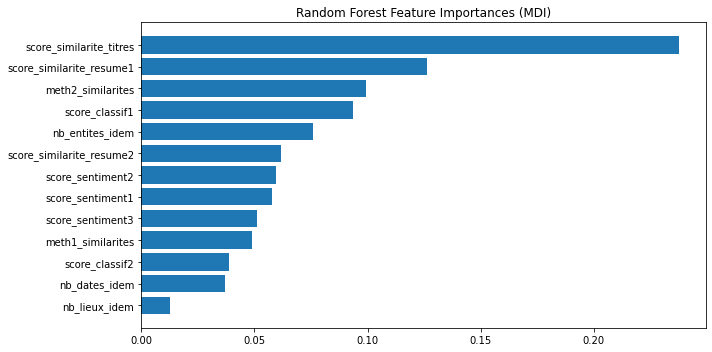

In [91]:
import matplotlib
import matplotlib.pyplot as plt
tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(predicteurs))
fig, ax = plt.subplots(figsize = (10,5))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.array(predicteurs)[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [92]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_lda = lda.predict(Xtrain[taille_train:])
res_final = pd.concat([res_rf[['Overall','RF']],pd.DataFrame(res_lda,columns = ['LDA'],index = range(taille_train,dernier_test))],axis=1)
res_final

,Overall,RF,LDA
100,3,2,3
101,1,3,3
102,4,4,4
103,4,4,4
104,4,4,4
...,...,...,...
186,4,4,4
187,1,2,2
188,2,3,2
189,3,3,4


In [93]:
from numpy import around
import numpy
np.set_printoptions(suppress=True)  # supprime notation exp
res_lda2 = around(lda.predict_proba(Xtrain[taille_train:])*100, decimals=2)
res_lda2

array([[  0.11,   0.57,  98.96,   0.36],
       [  4.18,   8.16,  84.78,   2.88],
       [  0.02,   0.42,  15.54,  84.02],
       [  0.01,   0.1 ,   4.58,  95.31],
       [  0.02,   4.06,  23.9 ,  72.02],
       [  2.34,  24.43,  44.73,  28.5 ],
       [  0.  ,   0.01,   2.2 ,  97.79],
       [  0.54,   1.42,  97.61,   0.43],
       [  0.01,   0.15,   8.92,  90.92],
       [  0.01,   0.01,   6.39,  93.59],
       [  0.69,   0.26,  68.56,  30.49],
       [ 77.93,  21.91,   0.16,   0.  ],
       [  0.  ,   0.  ,   1.68,  98.32],
       [  0.63,   0.24,  67.81,  31.32],
       [  0.34,   3.12,  51.63,  44.91],
       [  0.01,   0.03,   5.9 ,  94.06],
       [  0.  ,   0.02,  10.17,  89.81],
       [  0.1 ,   9.47,  19.81,  70.63],
       [  0.02,   0.19,  14.24,  85.55],
       [ 99.08,   0.89,   0.03,   0.  ],
       [ 92.72,   7.26,   0.02,   0.  ],
       [ 82.17,  16.15,   1.65,   0.04],
       [  0.16,   2.3 ,  27.68,  69.86],
       [  0.  ,  99.99,   0.  ,   0.  ],
       [  0.  , 

In [94]:
res_rf2 = around(rf.predict_proba(Xtrain[taille_train:])*100, decimals=2)
res_rf2

array([[  7.,  45.,  27.,  21.],
       [ 23.,  26.,  42.,   9.],
       [  6.,   6.,  13.,  75.],
       [  5.,  11.,   9.,  75.],
       [  0.,   6.,  17.,  77.],
       [  6.,  41.,  36.,  17.],
       [  1.,   0.,   5.,  94.],
       [ 17.,  33.,  19.,  31.],
       [  0.,   2.,  20.,  78.],
       [  0.,   1.,   8.,  91.],
       [ 10.,  11.,  39.,  40.],
       [ 27.,  57.,  11.,   5.],
       [  0.,   0.,   7.,  93.],
       [ 20.,   6.,  31.,  43.],
       [  3.,  29.,  31.,  37.],
       [  7.,   1.,  29.,  63.],
       [  2.,   1.,   3.,  94.],
       [  6.,  11.,  16.,  67.],
       [  2.,   0.,   8.,  90.],
       [ 59.,  24.,   9.,   8.],
       [ 67.,  24.,   7.,   2.],
       [ 43.,  29.,  19.,   9.],
       [  6.,  19.,  40.,  35.],
       [ 27.,  40.,  21.,  12.],
       [  1.,   0.,  13.,  86.],
       [  1.,   3.,  27.,  69.],
       [  3.,   7.,  24.,  66.],
       [ 21.,  30.,  39.,  10.],
       [ 14.,  15.,  28.,  43.],
       [  4.,  10.,  18.,  68.],
       [ 6

**_Remarquer que la classification ne tient pas compte du fait que c'est ordonné en classement 1-2-3-4 : ce qui est TRES important (ex : ligne 55% de 1 - 43% de 4) !! : il faudrait donc faire ressortir un score avec les probas plutot !!!_**

In [95]:
# Nouveau programme basé sur les scores probas : si plus de 50% mettre catégorie obtenue sinon, faire la somme 1-2 et 3/4 
# et prendre le plus gros score puis regarder si ce sore > 65% alors à ce moment là prendre le plus gros de la catégorie 
# sinon prendre 2 ou 3
def choix_classes(score_prob):
    classe_finale = []
    for i in range(len(score_prob)):
        res = list(score_prob[i,:])
        max_res = max(res)
        if max_res > 50:
            classe_finale.append(res.index(max_res)+1)
        else:
            som1 = res[0]+res[1]
            som2 = res[2]+res[3]
            if som1 > som2:
                if som1 >= 65:
                    choix = 1 if res[0]>res[1] else 2
                else:
                    choix = 2
            else:
                if som2 >= 65:
                    choix = 4 if res[3]>res[2] else 3
                else:
                    choix = 3
            classe_finale.append(choix)
    return classe_finale

In [96]:
liste_rf = choix_classes(res_rf2)
liste_lda = choix_classes(res_lda2)
res_final = pd.concat([res_final,pd.DataFrame(liste_lda,columns = ['LDA_Prob'],index = range(taille_train,dernier_test)),
                       pd.DataFrame(liste_rf,columns = ['RF_Prob'],index = range(taille_train,dernier_test))],axis=1)

In [97]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_knn = knn.predict(Xtrain[taille_train:])
liste_knn = choix_classes(around(knn.predict_proba(Xtrain[taille_train:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['KNN'],index = range(taille_train,dernier_test)),
                      pd.DataFrame(liste_knn,columns = ['KNN_Prob'],index = range(taille_train,dernier_test))],axis=1)

In [98]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_logreg = logreg.predict(Xtrain[taille_train:])
liste_logreg = choix_classes(around(logreg.predict_proba(Xtrain[taille_train:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_logreg,columns = ['LOGR'],index = range(taille_train,dernier_test)),
                      pd.DataFrame(liste_knn,columns = ['LOGR_Prob'],index = range(taille_train,dernier_test))],axis=1)

In [99]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_ada = ada.predict(Xtrain[taille_train:])
liste_ada = choix_classes(around(ada.predict_proba(Xtrain[taille_train:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['ADA'],index = range(taille_train,dernier_test)),
                      pd.DataFrame(liste_knn,columns = ['ADA_Prob'],index = range(taille_train,dernier_test))],axis=1)
res_final = res_final [['Overall','RF','LDA','KNN','LOGR','ADA','RF_Prob','LDA_Prob','KNN_Prob','LOGR_Prob','ADA_Prob']]

In [114]:
confusion_matrix(res_final.Overall,res_final.RF)

array([[ 8,  4,  1,  0],
       [ 7,  3,  1,  3],
       [ 0,  5,  7,  8],
       [ 0,  3,  2, 39]], dtype=int64)

In [115]:
confusion_matrix(res_final.Overall,res_final.RF_Prob)

array([[ 8,  4,  1,  0],
       [ 5,  4,  2,  3],
       [ 0,  5,  7,  8],
       [ 0,  3,  3, 38]], dtype=int64)

In [113]:
confusion_matrix(res_final.Overall,res_final.LDA)

array([[10,  2,  1,  0],
       [ 4,  5,  5,  0],
       [ 1,  4,  4, 11],
       [ 1,  2,  3, 38]], dtype=int64)

In [116]:
confusion_matrix(res_final.Overall,res_final.LDA_Prob)

array([[10,  2,  1,  0],
       [ 4,  5,  5,  0],
       [ 1,  4,  4, 11],
       [ 1,  3,  2, 38]], dtype=int64)

In [112]:
confusion_matrix(res_final.Overall,res_final.KNN)

array([[ 2,  6,  1,  4],
       [ 4,  6,  1,  3],
       [ 5,  5,  0, 10],
       [ 3,  6,  5, 30]], dtype=int64)

In [117]:
confusion_matrix(res_final.Overall,res_final.KNN_Prob)

array([[ 2,  6,  2,  3],
       [ 2,  8,  1,  3],
       [ 1,  7,  3,  9],
       [ 1,  7,  7, 29]], dtype=int64)

In [118]:
confusion_matrix(res_final.Overall,res_final.LOGR)

array([[ 9,  3,  1,  0],
       [ 3,  5,  3,  3],
       [ 1,  3,  4, 12],
       [ 1,  3,  1, 39]], dtype=int64)

In [119]:
# attention, ce n'est plus bon du tout ....
confusion_matrix(res_final.Overall,res_final.LOGR_Prob)

array([[ 2,  6,  2,  3],
       [ 2,  8,  1,  3],
       [ 1,  7,  3,  9],
       [ 1,  7,  7, 29]], dtype=int64)

In [121]:
confusion_matrix(res_final.Overall,res_final.ADA)

array([[ 2,  6,  1,  4],
       [ 4,  6,  1,  3],
       [ 5,  5,  0, 10],
       [ 3,  6,  5, 30]], dtype=int64)

In [120]:
confusion_matrix(res_final.Overall,res_final.ADA_Prob)

array([[ 2,  6,  2,  3],
       [ 2,  8,  1,  3],
       [ 1,  7,  3,  9],
       [ 1,  7,  7, 29]], dtype=int64)

## REGRESSION Sklearn Pycaret

In [100]:
from pycaret.regression import *
from sklearn.linear_model import LinearRegression
anglais = pd.read_csv('corpus_en_notes.csv',index_col=0)
# anglais2 = pd.read_csv('corpus_en_de_notes.csv',index_col=0)
# anglais = pd.concat([anglais,anglais2],axis=0).reset_index(drop=True)
anglais = anglais[anglais.meth1_similarites!='Error']
english_classif = setup(data = anglais[predicteurs + ['Overall']],  target = 'Overall', html=False, silent=True, verbose=False)

In [104]:
lr = create_model('lr')
rr = create_model('lasso')
etr = create_model('et')
svr = create_model('svm')
adar = create_model('ada')
mlpr = create_model('mlp')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7087,0.7993,0.8940,-0.1146,0.2608,0.2437
1,0.3694,0.2012,0.4486,0.8481,0.1670,0.1662
2,0.6331,0.6331,0.7957,0.5163,0.2630,0.3875
3,0.6552,0.7115,0.8435,0.4268,0.3269,0.2895
4,0.8844,1.2604,1.1227,-0.1704,0.3892,0.5134
5,0.7635,0.8805,0.9383,0.2251,0.2882,0.4284
6,0.7455,0.8614,0.9281,0.3479,0.2967,0.4467
7,0.5425,0.5305,0.7283,0.3987,0.1933,0.2438
8,0.7893,0.9168,0.9575,0.0485,0.3309,0.3862
9,0.5278,0.4370,0.6611,0.5251,0.1900,0.2311


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4118,0.4516,0.6720,0.3702,0.1809,0.1413
1,0.3412,0.1905,0.4365,0.8562,0.1221,0.1477
2,0.4931,0.4754,0.6895,0.6368,0.2395,0.3353
3,0.6455,0.5976,0.7730,0.5186,0.2328,0.2995
4,0.4244,0.3826,0.6185,0.6447,0.2175,0.2782
5,0.3267,0.1864,0.4317,0.8360,0.1302,0.1589
6,0.6523,0.6580,0.8112,0.5019,0.2501,0.3452
7,0.3374,0.1746,0.4178,0.8021,0.1343,0.1728
8,0.4010,0.2556,0.5056,0.7347,0.1458,0.1850
9,0.4590,0.3539,0.5949,0.6154,0.1763,0.2016


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3365,0.5679,0.7536,0.2081,0.2127,0.0981
1,0.3208,0.1657,0.4070,0.8750,0.1169,0.1467
2,0.5038,0.4618,0.6795,0.6472,0.2314,0.3098
3,0.5326,0.6217,0.7885,0.4992,0.2271,0.2250
4,0.4197,0.3187,0.5645,0.7041,0.1994,0.2627
5,0.4023,0.2728,0.5223,0.7599,0.1601,0.2109
6,0.5296,0.4962,0.7044,0.6244,0.2025,0.2273
7,0.4350,0.2756,0.5250,0.6876,0.1519,0.2035
8,0.4065,0.3171,0.5631,0.6709,0.1452,0.1573
9,0.4225,0.3024,0.5499,0.6714,0.1674,0.1860


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3450,0.4261,0.6528,0.4058,0.1767,0.1114
1,0.3326,0.1886,0.4343,0.8576,0.1245,0.1496
2,0.3911,0.3296,0.5741,0.7482,0.2081,0.2789
3,0.6158,0.6415,0.8009,0.4832,0.2386,0.2882
4,0.4528,0.4603,0.6785,0.5726,0.2355,0.3078
5,0.3099,0.1880,0.4336,0.8346,0.1312,0.1570
6,0.6224,0.5469,0.7395,0.5860,0.2286,0.3165
7,0.3996,0.2395,0.4894,0.7286,0.1600,0.2094
8,0.4851,0.3560,0.5966,0.6306,0.1645,0.2082
9,0.4324,0.3907,0.6251,0.5754,0.1863,0.1981


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4187,0.5372,0.7329,0.2509,0.1991,0.1183
1,0.4248,0.2544,0.5043,0.8080,0.1426,0.1896
2,0.5788,0.5569,0.7463,0.5745,0.2469,0.3417
3,0.6192,0.7310,0.8550,0.4111,0.2495,0.2692
4,0.4663,0.4230,0.6504,0.6072,0.2267,0.2990
5,0.3907,0.2649,0.5147,0.7669,0.1545,0.1962
6,0.7240,0.8660,0.9306,0.3444,0.2747,0.3185
7,0.3898,0.1825,0.4272,0.7931,0.1277,0.1774
8,0.4137,0.2975,0.5454,0.6913,0.1455,0.1647
9,0.5473,0.4408,0.6639,0.5211,0.1940,0.2336


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7842,1.0789,1.0387,-0.5046,0.2901,0.2401
1,0.5428,0.4740,0.6885,0.6422,0.2006,0.2496
2,0.6078,0.7052,0.8398,0.4613,0.2515,0.3006
3,0.8579,1.2575,1.1214,-0.0131,0.3469,0.5123
4,0.4564,0.2942,0.5424,0.7268,0.1770,0.2271
5,0.5534,0.3729,0.6107,0.6718,0.1767,0.2659
6,0.7702,0.9070,0.9524,0.3134,0.2957,0.4486
7,0.4655,0.3375,0.5809,0.6175,0.1997,0.2476
8,1.0293,1.5964,1.2635,-0.6568,0.3252,0.4653
9,0.5850,0.5592,0.7478,0.3923,0.2007,0.2273


In [105]:
# Linear Regression simple sur scikit learn
essai_classif = anglais[['Geography','Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone','nb_entites_idem', 
    'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1','score_similarite_resume2', 
    'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'score_sentiment3','meth1_similarites','meth2_similarites']]
lr = LinearRegression()
Xtrain = essai_classif[predicteurs].reset_index(drop=True)
ytrain = essai_classif['Overall'].reset_index(drop=True)

In [107]:
lr.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_lr = lr.predict(Xtrain[taille_train:])
res_lr = pd.concat([Xtrain[taille_train:],ytrain[taille_train:],pd.DataFrame(res_lr,columns = ['LR'],index = range(taille_train,dernier_test))],axis=1)
res_lr

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,score_sentiment3,meth1_similarites,meth2_similarites,Overall,LR
100,10,0,7,16.92,13.18,12.12,55.78,8.34,20.98,6.82,97.85,526.2,408.0,3.000000,2.975029
101,5,0,2,15.11,30.88,9.29,32.23,8.32,24.34,98.09,96.14,419.6,421.1,1.333333,2.655848
102,0,0,4,4.68,4.31,5.74,10.86,8.51,35.78,98.09,99.48,367.1,453.2,3.666667,3.587408
103,12,0,4,3.08,2.45,3.82,10.04,8.33,20.46,61.80,79.66,253.3,327.2,3.666667,3.704653
104,2,2,7,7.41,14.68,22.20,13.71,8.35,18.03,2.12,63.97,239.6,140.1,3.666667,3.439632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0,0,2,1.78,4.27,10.28,8.92,8.29,19.18,90.36,5.42,51.9,185.6,4.000000,3.920088
187,7,0,0,25.11,28.36,22.68,20.06,8.37,21.05,17.43,99.57,196.9,735.7,1.000000,1.996764
188,3,0,6,7.94,29.86,-1.50,32.86,8.35,26.32,5.13,95.33,654.8,1324.8,2.333333,2.447097
189,0,0,0,13.93,13.98,11.86,13.83,8.32,21.20,14.38,99.43,179.4,129.4,2.666667,3.289070


In [108]:
res_final = pd.concat([res_final,res_lr['LR']],axis=1)

In [109]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression()
pls.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_pls = list(pls.predict(Xtrain[taille_train:]).flatten())
res_pls = pd.concat([res_lr,pd.DataFrame(res_pls,columns = ['PLS'],index = range(taille_train,dernier_test))],axis=1)
res_pls

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,score_sentiment3,meth1_similarites,meth2_similarites,Overall,LR,PLS
100,10,0,7,16.92,13.18,12.12,55.78,8.34,20.98,6.82,97.85,526.2,408.0,3.000000,2.975029,2.236149
101,5,0,2,15.11,30.88,9.29,32.23,8.32,24.34,98.09,96.14,419.6,421.1,1.333333,2.655848,2.305216
102,0,0,4,4.68,4.31,5.74,10.86,8.51,35.78,98.09,99.48,367.1,453.2,3.666667,3.587408,3.555531
103,12,0,4,3.08,2.45,3.82,10.04,8.33,20.46,61.80,79.66,253.3,327.2,3.666667,3.704653,3.539568
104,2,2,7,7.41,14.68,22.20,13.71,8.35,18.03,2.12,63.97,239.6,140.1,3.666667,3.439632,3.312935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0,0,2,1.78,4.27,10.28,8.92,8.29,19.18,90.36,5.42,51.9,185.6,4.000000,3.920088,3.815560
187,7,0,0,25.11,28.36,22.68,20.06,8.37,21.05,17.43,99.57,196.9,735.7,1.000000,1.996764,2.014655
188,3,0,6,7.94,29.86,-1.50,32.86,8.35,26.32,5.13,95.33,654.8,1324.8,2.333333,2.447097,2.151264
189,0,0,0,13.93,13.98,11.86,13.83,8.32,21.20,14.38,99.43,179.4,129.4,2.666667,3.289070,3.340806


In [110]:
res_final = pd.concat([res_final,res_pls['PLS']],axis=1)

In [111]:
res_final

,Overall,RF,LDA,KNN,LOGR,ADA,RF_Prob,LDA_Prob,KNN_Prob,LOGR_Prob,ADA_Prob,LR,PLS
100,3,2,3,2,3,2,2,3,3,3,3,2.975029,2.236149
101,1,3,3,4,3,4,3,3,4,4,4,2.655848,2.305216
102,4,4,4,2,4,2,4,4,2,2,2,3.587408,3.555531
103,4,4,4,2,4,2,4,4,3,3,3,3.704653,3.539568
104,4,4,4,4,4,4,4,4,4,4,4,3.439632,3.312935
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,4,4,4,4,4,4,4,4,4,4,4,3.920088,3.815560
187,1,2,2,2,2,2,2,2,2,2,2,1.996764,2.014655
188,2,3,2,2,2,2,3,2,2,2,2,2.447097,2.151264
189,3,3,4,4,3,4,3,4,4,4,4,3.289070,3.340806


**Pour le classement final utiliser aussi la stade de base des notations : si plus de 4 ....** <br/>
**Pour le seuils : Le mieux est d'utiliser un algo qui regrade les erreurs des autres ... NB / LR**

In [150]:
# on ne garde finalement que LDA - RF et LR en classif et sans les probas qui changent peu finalement
def choix_final(df):
    res = pd.DataFrame(columns = ['Overall','Classif_value','Regression_value','Classif','Regression','Final','Final_aide'])
    for i in range(df.index[0],df.index[len(df)-1]):
        my_dic = {}
        my_dic['Overall'] = df.Overall[i]                   
        my_dic['Classif_value'] = round((df.RF[i] + df.LDA[i] + df.LOGR[i])/3,2)
        my_dic['Regression_value'] = round((df.LR[i] + df.PLS[i])/2,2)
        if my_dic['Classif_value'] < 1.7:
            my_dic['Classif'] = 1
        elif my_dic['Classif_value'] < 2.5:
            my_dic['Classif'] = 2
        elif my_dic['Classif_value'] < 3.25:
            my_dic['Classif'] = 3
        else:
            my_dic['Classif'] = 4
        if my_dic['Regression_value'] <= 1.6:
            my_dic['Regression'] = 1
        elif my_dic['Regression_value'] < 2.5:
            my_dic['Regression'] = 2
        elif my_dic['Regression_value'] < 3.5:
            my_dic['Regression'] = 3
        else:
            my_dic['Regression'] = 4
        diff = 0.01 if my_dic['Classif'] != my_dic['Regression'] else 0
        diff += 0.005 if abs(my_dic['Classif']-my_dic['Regression'])>=2 else 0
        my_dic['Final'] = round((my_dic['Classif']+my_dic['Regression'])/2,0)
        my_dic['Final_aide'] = round((my_dic['Classif']+my_dic['Regression'])/2,0)+diff
        res.loc[len(res)] = my_dic
        
    return res

In [151]:
vote = choix_final(res_final)
vote

,Overall,Classif_value,Regression_value,Classif,Regression,Final,Final_aide
0,3.0,2.67,2.61,3.0,3.0,3.0,3.00
1,1.0,3.00,2.48,3.0,2.0,2.0,2.01
2,4.0,4.00,3.57,4.0,4.0,4.0,4.00
3,4.0,4.00,3.62,4.0,4.0,4.0,4.00
4,4.0,4.00,3.38,4.0,3.0,4.0,4.01
...,...,...,...,...,...,...,...
85,4.0,4.00,3.85,4.0,4.0,4.0,4.00
86,4.0,4.00,3.87,4.0,4.0,4.0,4.00
87,1.0,2.00,2.01,2.0,2.0,2.0,2.00
88,2.0,2.33,2.30,2.0,2.0,2.0,2.00


In [153]:
#plutôt moins bon que la classif : peut etre question de seuil ...
confusion_matrix(vote.Overall,vote.Regression)

array([[ 7,  5,  0,  0],
       [ 5,  4,  5,  0],
       [ 0,  4, 10,  6],
       [ 0,  2, 12, 30]], dtype=int64)

In [152]:
# Ne sert à rien pratiquement, mais seuils à voir
confusion_matrix(vote.Overall,vote.Final)

array([[ 7,  5,  0,  0],
       [ 3,  6,  2,  3],
       [ 0,  4,  3, 13],
       [ 0,  4,  1, 39]], dtype=int64)

**REMARQUE GENERALE : IL Y A BCP DE 4 ce qui aide beaucoup**